<a href="https://colab.research.google.com/github/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/blob/master/Train_TFLite2_Object_Detction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Lite Object Detection API in Colab
**Author:** Evan Juras, [EJ Technology Consultants](https://ejtech.io)

**Last updated:** 9/9/22

# Introduction


This notebook uses [the TensorFlow 2 Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) to train an SSD-MobileNet model or EfficientDet model with a custom dataset and convert it to TensorFlow Lite format. By working through this Colab, you'll be able to create and download a TFLite model that you can run on your PC, an Android phone, or an edge device like the Raspberry Pi.

*GIF of custom TFLite model in action to be added here*

### Working in Colab
Colab provides a virtual machine (VM) in your browser complete with a Linux OS, filesystem, Python environment, and best of all, a free GPU. It comes with most TensorFlow backend requirements (like CUDA and cuDNN) pre-installed.

Simply click the play button on sections of code to execute them on the VM. As the code executes, any outputs will be displayed in a block beneath the code. Once they're done executing, a green checkmark will appear next to the section to indicate it's finished running.

*Note: Make sure you're using a GPU-equipped machine by going to "Runtime" -> "Change runtime type" in the top menu bar, and then selecting "GPU" from the Hardware accelerator dropdown.*

### Notes on TensorFlow Versions
* The latest version of TensorFlow this Colab has been verified to work with is TF v2.8.0.
* This Colab notebook uses TensorFlow 2. If you'd like to use TensorFlow 1, please see my TF1 Colab notebook *(link to be added)*.

# 1. Gather and Label Training Images
Before we start training, we need to gather and label images that will be used for training the object detection model. A good starting point for a proof-of-concept model is 200 images.

TensorFlow needs hundreds of images of an object to train a good object detector. The training images should have random objects in the image along with the desired objects, and should have a variety of backgrounds and lighting conditions. There should be some images where the desired object is partially obscured, overlapped with something else, or only halfway in the picture.

Watch the YouTube video below for instructions and tips on how to gather and label images for training an object detection model.

*Link to YouTube video*

When you've finished gathering and labeling images, you should have a folder full of images and corresponding .xml data annotation file for each image. Examples of labeled images and an image folder for my cat toy detector are shown below.

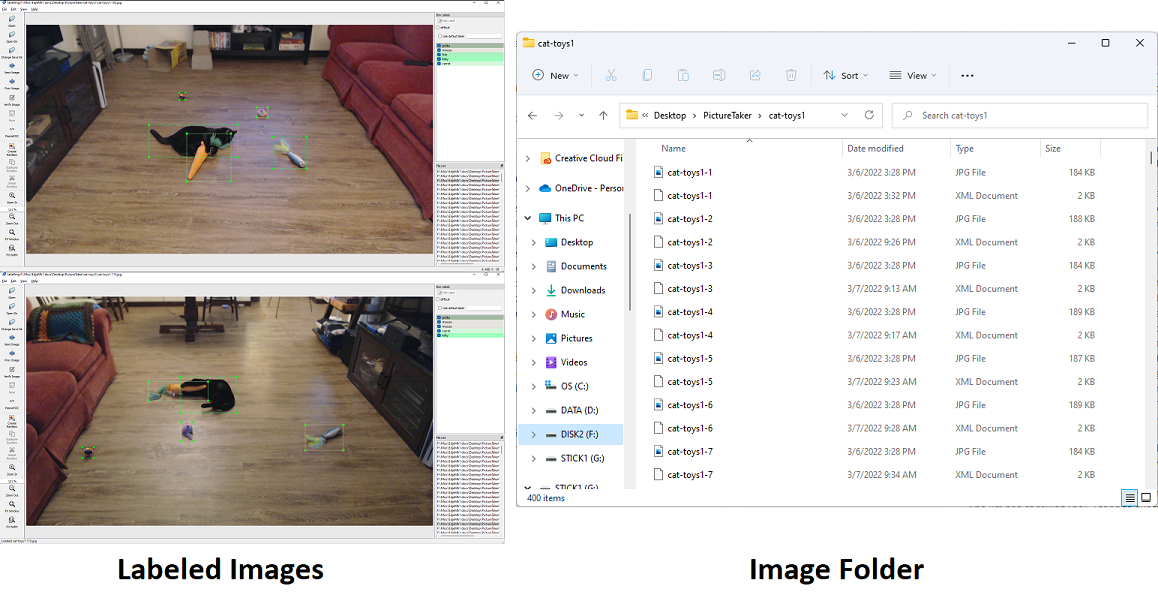

# 2. Install TensorFlow Object Detection Dependencies
First, we'll install the TensorFlow Object Detection API in this Google Colab instance. This requires cloning the [TensorFlow models repository](https://github.com/tensorflow/models) and running a couple installation commands. Click the play button to run the following sections of code.



In [ ]:
# Clone the tensorflow models repository from GitHub
!git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
# Copy setup files into models/research folder
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .

In [ ]:
# Install the Object Detection API
!pip install /content/models/research/

# Need to downgrade to TF v2.8.0 due to Colab compatibility bug with TF v2.9 (as of 8/30/22)
!pip install tensorflow==2.8.0

You may get warnings or errors related to package dependencies in the previous code block, but you can ignore them for now. 

Let's test our installation by running `model_builder_tf2_test.py` to make sure everything is working as expected. Run the following code block and confirm that it finishes without errors. If you get errors, try Googling them or checking the FAQ at the end of this Colab.

In [ ]:
# Run Model Bulider Test file, just to verify everything's working properly
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py


# 3. Upload Image Dataset and Prepare Training Data

In this section, we'll upload our data and prepare it for training with TensorFlow. We'll upload our images, split them into train, validation, and test folders, and then run scripts for creating TFRecords from our data.

First, on your local PC, zip all your training images and XML files into a single folder called "images.zip". The files should be directly inside the zip folder (wihout any additional nested folders) as shown below:
```
images.zip
-- img1.jpg
-- img1.xml
-- img2.jpg
-- img2.xml
...
```
There are two options for moving the image files to this Colab instance: you can upload them directly, or you can copy them from your Google Drive. If you have a slow internet connection or more than 50MB worth of images, I recommend using Google Drive. Otherwise, you can just upload them through Colab. 

#### Option 1. Upload through Google Colab
Upload the "images.zip" file to the Google Colab instance by clicking the "Files" icon on the left hand side of the browser, and then the "Upload to session storage" icon. Select the zip folder to upload it.

![](https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/doc/colab_upload_button.png)

Once it's uploaded, we'll run a few commands to unzip it and set up our image directories. These directories are created in the /content folder in this instance's filesystem. You can browse the filesystem by clicking the "Files" icon on the left.


#### Option 2. Copy from Google Drive
You can also upload your images to your personal Google Drive, mount the drive on this Colab session, and copy them over to the Colab filesystem. This option works well if you want to upload the images beforehand so you don't have to wait for them to upload each time you restart this Colab.

First, upload the "images.zip" file to your Google Drive, and make note of the folder you uploaded them to. Replace `MyDrive/path/to/images.zip` with the path to your zip file. (For example, I uploaded the zip file to folder called "cat-toys1", so I would use `MyDrive/cat-toys1/images.zip` for the path). Then, run the following block of code to mount your Google Drive to this Colab session and copy the folder to this filesystem.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp /content/gdrive/MyDrive/cat-toys1/images.zip /content

#### Option 3. Use my bird, squirrel, raccoon dataset
I've uploaded a dataset containing 800 labeled images of birds, squirrels, and raccoons. You can use this dataset if you just want to work through the process of training a TFLite model on custom data. Run the following code block to download the dataset.

In [ ]:
!wget -O /content/images.zip https://www.dropbox.com/s/en33x280e4z3wbt/BSR2.zip?dl=0 

## Split images into train, validation, and test folders
At this point, whether you used Option 1 or Option 2, you should be able to click the folder icon on the left and see your "images.zip" file in the list of files. Now that the dataset is uploaded, let's unzip it and create some folders to hold the images.

In [ ]:
!mkdir /content/images
!unzip -q images.zip -d /content/images/all
!mkdir /content/images/train; mkdir /content/images/validation; mkdir /content/images/test


Next, we'll split the images into train, validation, and test sets. Here's what each set is used for:



*   **Train**: These are the actual images used to train the model. In each step of training, a batch of images from the "train" set is passed into the neural network. The network predicts classes and locations of objects in the images. The training algorithm calculates the loss (i.e. how "wrong" the predictions were) and adjusts the network weights through backpropagation.


*   **Validation**: Images from the "validation" set can be used by the training algorithm to check the progress of training and adjust hyperparameters (like learning rate). Unlike "train" images, these images are only used periodically during training (i.e. once every certain number of training steps).


* **Test**: These images are never seen by the neural network during training. They are intended to be used by a human to perform final testing of the model to check how accurate the model is.

I wrote a Python script to randomly move 80% of the images to the "train" folder, 10% to the "validation" folder, and 10% to the "test" folder. Click play on the following block to download the script and execute it.

In [ ]:
!wget https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/util_scripts/train_val_test_split.py
!python train_val_test_split.py

Finally, we need to convert the images into a data file format called TFRecords, which are used by TensorFlow for training. We'll use Python scripts to automatically convert the data into TFRecord format. Before running them, we need to define a labelmap for our classes. 

The code section below will create a "labelmap.txt" file that contains a list of classes. Replace the `class1`, `class2`, `class3` text with your own classes (for example, `bird`, `squirrel`, `raccoon`), adding a new line for each class. Then, click play to execute the code.

In [ ]:
### This creates a a "labelmap.txt" file with a list of classes the object detection model will detect.
%%bash
cat <<EOF >> /content/labelmap.txt
class1
class2
class3
EOF

Download and run the data conversion scripts by clicking play on the following three sections of code. They will create TFRecord files for the train and validation datasets, as well as a `labelmap.pbtxt` file which contains the labelmap in a different format.

In [ ]:
# Download data conversion scripts
! wget https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/util_scripts/create_csv.py
! wget https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/util_scripts/create_tfrecord.py

In [ ]:
# Create CSV data files and TFRecord files
!python3 create_csv.py
!python3 create_tfrecord.py --csv_input=images/train_labels.csv --labelmap=labelmap.txt --image_dir=images/train --output_path=train.tfrecord
!python3 create_tfrecord.py --csv_input=images/validation_labels.csv --labelmap=labelmap.txt --image_dir=images/validation --output_path=val.tfrecord

We'll store the locations of the TFRecord and labelmap files as variables so we can reference them later in this Colab session.

In [ ]:
train_record_fname = '/content/train.tfrecord'
val_record_fname = '/content/val.tfrecord'
label_map_pbtxt_fname = '/content/labelmap.pbtxt'

# 4. Set Up Training Configuration 

In this section, we'll set up an SSD-MobileNet model training configuration. We'll specifiy which pretrained TensorFlow model we want to use from the [TensorFlow 2 Object Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md). Each model also comes with a configuration file that points to file locations, sets training parameters (such as learning rate and total number of training steps), and more. We'll modify the configuration file for our custom training job.

The first section of code lists out some models availabe in the TF2 Model Zoo and defines some filenames that will be used later to download the model and config file. This makes it easy to manage which model you're using and to add other models to the list later. 

Set the "chosen_model" variable to match the name of the model you'd like to train with. It's currently set to use the popular "ssd-mobilenet-v2" model. Then, click play on the next three sections to specify and download the pretrained model file and configuration file.

In [ ]:
# Change the chosen_model variable to deploy different models available in the TF2 object detection zoo
chosen_model = 'ssd-mobilenet-v2'

MODELS_CONFIG = {
    'ssd-mobilenet-v2': {
        'model_name': 'ssd_mobilenet_v2_320x320_coco17_tpu-8',
        'base_pipeline_file': 'ssd_mobilenet_v2_320x320_coco17_tpu-8.config',
        'pretrained_checkpoint': 'ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz',
    },
    'efficientdet-d0': {
        'model_name': 'efficientdet_d0_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d0_512x512_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d0_coco17_tpu-32.tar.gz',
    },
    'ssd-mobilenet-v2-fpnlite-320': {
        'model_name': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8',
        'base_pipeline_file': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config',
        'pretrained_checkpoint': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz',
    },
    # The centernet model isn't working as of 9/10/22
    #'centernet-mobilenet-v2': {
    #    'model_name': 'centernet_mobilenetv2fpn_512x512_coco17_od',
    #    'base_pipeline_file': 'pipeline.config',
    #    'pretrained_checkpoint': 'centernet_mobilenetv2fpn_512x512_coco17_od.tar.gz',
    #}
}

model_name = MODELS_CONFIG[chosen_model]['model_name']
pretrained_checkpoint = MODELS_CONFIG[chosen_model]['pretrained_checkpoint']
base_pipeline_file = MODELS_CONFIG[chosen_model]['base_pipeline_file']

In [ ]:
# Create "mymodel" folder for holding pre-trained weights and configuration files
%mkdir /content/models/mymodel/
%cd /content/models/mymodel/

# Download pre-trained model weights
import tarfile
download_tar = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/' + pretrained_checkpoint
if chosen_model == 'centernet-mobilenet-v2':
  download_tar = 'http://download.tensorflow.org/models/object_detection/tf2/20210210/' + pretrained_checkpoint

!wget {download_tar}
tar = tarfile.open(pretrained_checkpoint)
tar.extractall()
tar.close()

# Download training configuration file for model
download_config = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/' + base_pipeline_file
if chosen_model == 'centernet-mobilenet-v2':
  !cp /content/models/mymodel/centernet_mobilenetv2_fpn_od/pipeline.config /content/models/mymodel

else:
  !wget {download_config}
#!wget {download_config}

Now that we've downloaded our model and config file, we need to modify the configuration file with some high-level training parameters. The following variables are used to control training steps:

* **num_steps**: The total amount of steps to use for training the model. A good number to start with is 40,000 steps. You can use more steps if you notice the loss metrics are still decreasing by the time training finishes. The more steps, the longer the training. Training can also be stopped early if loss flattens out before reaching the specified number of steps.
* **batch_size**: The number of images to use per training step. A larger batch size allows a model to be trained in fewer steps, but the size is limited by the GPU memory available for training. For the GPUs used in Colab instances, 16 is typically a good number.

Other training information, like the location of the pretrained model file, the config file, and total number of classes are also assigned in this step.

In [ ]:
# Set training parameters for the model
num_steps = 40000
batch_size = 16

In [ ]:
# Set file locations and get number of classes for config file
pipeline_fname = '/content/models/mymodel/' + base_pipeline_file
fine_tune_checkpoint = '/content/models/mymodel/' + model_name + '/checkpoint/ckpt-0'

def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())
num_classes = get_num_classes(label_map_pbtxt_fname)
print('Total classes:', num_classes)


Next, we'll rewrite the config file to use the training parameters we just specified. The following section of code will automatically replace the necessary parameters in the downloaded .config file and save it as our custom "pipeline_file.config" file.

In [ ]:
# Create custom configuration file by writing the dataset, model checkpoint, and training parameters into the base pipeline file
import re

%cd /content/models/mymodel
print('writing custom configuration file')

with open(pipeline_fname) as f:
    s = f.read()
with open('pipeline_file.config', 'w') as f:
    
    # Set fine_tune_checkpoint path
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # Set tfrecord files for train and test datasets
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 'input_path: "{}"'.format(val_record_fname), s)

    # Set label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set batch_size
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)

    # Change fine-tune checkpoint type from "classification" to "detection"
    s = re.sub(
        'fine_tune_checkpoint_type: "classification"', 'fine_tune_checkpoint_type: "{}"'.format('detection'), s)
    
    # If using ssd-mobilenet-v2, reduce learning rate (because it's too high in the default config file)
    if chosen_model == 'ssd-mobilenet-v2':
      s = re.sub('learning_rate_base: .8',
                 'learning_rate_base: .08', s)
      
      s = re.sub('warmup_learning_rate: 0.13333',
                 'warmup_learning_rate: .026666', s)
    
    # If using efficientdet-d0, use fixed_shape_resizer instead of keep_aspect_ratio_resizer (because it isn't supported by TFLite)
    if chosen_model == 'efficientdet-d0':
      s = re.sub('keep_aspect_ratio_resizer', 'fixed_shape_resizer', s)
      s = re.sub('pad_to_max_dimension: true', '', s)
      s = re.sub('min_dimension', 'height', s)
      s = re.sub('max_dimension', 'width', s)

    f.write(s)


(Optional) If you're curious, you can display the configuration file's contents here in the browser by running the line of code below.

In [ ]:
# (Optional) Display the custom configuration file's contents
!cat /content/models/mymodel/pipeline_file.config

Finally, let's set the locations of the configuration file and model output directory as variables so we can reference them when we call the training command.

In [ ]:
# Set the path to the custom config file and the directory to store training checkpoints in
pipeline_file = '/content/models/mymodel/pipeline_file.config'
model_dir = '/content/training/'

# 5. Train Custom TFLite Detection Model

We're ready to train our object detection model! Before we start training, let's load up a TensorBoard session to monitor training progress. Run the following section of code, and a TensorBoard session will appear in the browser. It won't show anything yet, because we haven't started training. Once training starts, come back and click the refresh button to see the model's overall loss.



In [ ]:
%load_ext tensorboard
%tensorboard --logdir '/content/training/train'

Model training is performed using the "model_main_tf2.py" script from the TF Object Detection API. It takes a variety of input arguments, including:

* **pipeline_config_path**: Path to the training config file, which we created above
* **model_dir**: the location tensorboard logs and saved model checkpoints will save to
* **num_train_steps**: how many steps to train for

We've already defined these arguments in previous sections of this Colab. Just click Play on the following block to begin training! Training will take about 3 hours.

*(Note: If you want to stop training early, just click on the code block while it's running and press Ctrl+M to interrupt execution. You might have to press Ctrl+M a couple times and also click the Stop button or right-click and select "Interrupt Execution".)*

In [ ]:
# Run training!
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --sample_1_of_n_eval_examples=1

Once training is finished, you can calculate your model's overall precision and accuracy on the **validation** images. Object detection model accuracy is measured in mAP or "mean average precision". Basically, the higher the mAP score, the better your model is at detecting objects in images. To learn more about mAP, read through this [article from Roboflow](https://blog.roboflow.com/mean-average-precision/).

Run the following code block to calculate mAP score. It will output several values, look for the one that says:

` Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ]`

The score reported at the right end of this row is your model's overall mAP score. Ideally, it should be above 50% (0.50). If it isn't, you can increase your model's accuracy by adding more images to your dataset. (See my dataset video (*link to be added*) for tips on how to capture good training images and improve accuracy.) Later on in this notebook, we'll test the model on images from the **test** folder so you can see how well the model actually performs.

**Important: The evaluation script will run indefinitely until it's manually interrupted. Click the Stop button or right-click on the code cell and select "Interrupt execution" to halt the script before moving on to the next section.**

In [ ]:
# Calculate trained model's mAP score
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --checkpoint_dir={model_dir} \
    --alsologtostderr

**Don't forget to click Stop on the previous code block before moving on!**

# 6. Convert Model to TensorFlow Lite

Alright! Our model is all trained up and ready to be used for detecting objects. First, we need to export the model graph (a file that contains information about the architecture and weights) to a TensorFlow Lite-compatible format. We'll do this using the `export_tflite_graph_tf2.py` script.

In [ ]:
# Make a directory to store the trained TFLite model
!mkdir /content/custom_model_lite
output_directory = '/content/custom_model_lite'

# Path to training directory (the conversion script automatically chooses the highest checkpoint file)
last_model_path = '/content/training'

!python /content/models/research/object_detection/export_tflite_graph_tf2.py \
    --trained_checkpoint_dir {last_model_path} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_file}


Next, we'll take the exported graph and use the `TFLiteConverter` module to convert it to `.tflite` FlatBuffer format.

In [ ]:
# Convert exported graph file into TFLite model file
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model('/content/custom_model_lite/saved_model')
tflite_model = converter.convert()

with open('/content/custom_model_lite/detect.tflite', 'wb') as f:
  f.write(tflite_model)

# 7. Test TensorFlow Lite Model
Okay, we've trained our custom model and converted it to TFLite format. But how well does it actually perform at detecting objects in images? This is where the images we set aside in the **test** folder come in. The model never saw any test images during training, so its performance on these images should be representative of how it will perform on new images from the field.

The following script runs the newly trained detection model on images in the `content/images/test` folder. It loads the images, loads the model and labelmap, runs the model on each image, and displays the result. Change `images_to_test` if you want to run it on more than 10 images.

This code is based off the [TFLite_detection_image.py](https://github.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/blob/master/TFLite_detection_image.py) script from my [TensorFlow Lite Object Detection repository on GitHub](https://github.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi); feel free to use it as a starting point for your own application. Click Play on the two code blocks below to test out your model!

In [ ]:
# Script to run custom TFLite model on test images to detect objects
# Source: https://github.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/blob/master/TFLite_detection_image.py

# Import packages
import os
import cv2
import numpy as np
import sys
import glob
import importlib.util
from tensorflow.lite.python.interpreter import Interpreter

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

### Define function for inferencing with TFLite model and displaying results

def tflite_detect_images(modelpath, imgpath, lblpath, min_conf=0.5, num_test_images=10):

  # Grab filenames of all images in test folder
  images = glob.glob(imgpath + '/*.jpg')
  images = images + glob.glob(imgpath + '/*.JPG')
  images = images + glob.glob(imgpath + '/*.png')
  images = images + glob.glob(imgpath + '/*.bmp')

  # Load the label map into memory
  with open(lblpath, 'r') as f:
      labels = [line.strip() for line in f.readlines()]

  # Load the Tensorflow Lite model into memory
  interpreter = Interpreter(model_path=modelpath)
  interpreter.allocate_tensors()

  # Get model details
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  height = input_details[0]['shape'][1]
  width = input_details[0]['shape'][2]

  float_input = (input_details[0]['dtype'] == np.float32)

  input_mean = 127.5
  input_std = 127.5

  # Loop over every image and perform detection
  for image_path in images[0:num_test_images]:

      # Load image and resize to expected shape [1xHxWx3]
      image = cv2.imread(image_path)
      image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      imH, imW, _ = image.shape 
      image_resized = cv2.resize(image_rgb, (width, height))
      input_data = np.expand_dims(image_resized, axis=0)

      # Normalize pixel values if using a floating model (i.e. if model is non-quantized)
      if float_input:
          input_data = (np.float32(input_data) - input_mean) / input_std

      # Perform the actual detection by running the model with the image as input
      interpreter.set_tensor(input_details[0]['index'],input_data)
      interpreter.invoke()

      # Retrieve detection results
      boxes = interpreter.get_tensor(output_details[1]['index'])[0] # Bounding box coordinates of detected objects
      classes = interpreter.get_tensor(output_details[3]['index'])[0] # Class index of detected objects
      scores = interpreter.get_tensor(output_details[0]['index'])[0] # Confidence of detected objects

      # Loop over all detections and draw detection box if confidence is above minimum threshold
      for i in range(len(scores)):
          if ((scores[i] > min_conf) and (scores[i] <= 1.0)):

              # Get bounding box coordinates and draw box
              # Interpreter can return coordinates that are outside of image dimensions, need to force them to be within image using max() and min()
              ymin = int(max(1,(boxes[i][0] * imH)))
              xmin = int(max(1,(boxes[i][1] * imW)))
              ymax = int(min(imH,(boxes[i][2] * imH)))
              xmax = int(min(imW,(boxes[i][3] * imW)))
              
              cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (10, 255, 0), 2)

              # Draw label
              object_name = labels[int(classes[i])] # Look up object name from "labels" array using class index
              label = '%s: %d%%' % (object_name, int(scores[i]*100)) # Example: 'person: 72%'
              labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2) # Get font size
              label_ymin = max(ymin, labelSize[1] + 10) # Make sure not to draw label too close to top of window
              cv2.rectangle(image, (xmin, label_ymin-labelSize[1]-10), (xmin+labelSize[0], label_ymin+baseLine-10), (255, 255, 255), cv2.FILLED) # Draw white box to put label text in
              cv2.putText(image, label, (xmin, label_ymin-7), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2) # Draw label text

      # All the results have been drawn on the image, now display the image
      image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
      plt.figure(figsize=(12,16))
      plt.imshow(image)
      plt.show()

  return



In [ ]:
# Set up variables for running user's model
PATH_TO_IMAGES='/content/images/test'   #Path to test images folder
PATH_TO_MODEL='/content/custom_model_lite/detect.tflite'   #Path to .tflite model file
PATH_TO_LABELS='/content/labelmap.txt'   #Path to labelmap.txt file
min_conf_threshold=0.5   #Confidence threshold (try changing this to 0.01 if you don't see any detection results)
images_to_test = 10   #Number of images to run detection on

# Run inferencing function!
tflite_detect_images(PATH_TO_MODEL, PATH_TO_IMAGES, PATH_TO_LABELS, min_conf_threshold, images_to_test)

# 8. Deploy TensorFlow Lite Model
Now that your custom model has been trained and converted to TFLite format, it's ready to be downloaded and deployed in an application! This section shows how to download the model and provides links to instructions for deploying it on the Raspberry Pi, your PC, or other edge devices.

## 8.1 Download TFLite model

Run the two following cells to copy the labelmap files into the model folder, compress it into a zip folder, and then download it. The zip folder contains the `detect.tflite` model and `labelmap.txt` labelmap files that are needed to run the model in your application.

In [ ]:
# Move labelmap file into TFLite model folder and zip it up
!cp /content/labelmap.txt /content/custom_model_lite
!cp /content/labelmap.pbtxt /content/custom_model_lite
!zip -r /content/custom_model_lite.zip /content/custom_model_lite

In [ ]:
from google.colab import files

files.download('/content/custom_model_lite.zip')

The `custom_model_lite.zip` file containing the model will download into your Downloads folder. It's ready to be deployed on your device!

## 8.2. Deploy model on Raspberry Pi
TFLite models are great for running on the Raspberry Pi, because they require less processing power than regular TensorFlow vision models. The Pi can run TFLite models in near real-time. The table below shows how fast each model from this guide will run on Raspberry Pi 4 8GB hardware.

To run your new model on the Raspberry Pi, you'll have to install TensorFlow Lite and prepare a Python environment for your application. I provide step-by-step instructions on how to set up TFLite on the Pi in my video, [How To Run TensorFlow Lite on Raspberry Pi for Object Detection](https://youtu.be/aimSGOAUI8Y).

[![Link to my YouTube video!](https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/doc/YouTube_video1.JPG)](https://www.youtube.com/watch?v=aimSGOAUI8Y)

Once you've completed all the steps in the video, move the `custom_model_lite.zip` file downloaded from this Colab session over to your Raspberry Pi into the `~/tflite1` folder. Move into the folder and unzip it by issuing:

```
cd ~/tflite1`
unzip custom_model_lite.zip
```

Then, run the image, video, or webcam TFLite detection program with the `--modeldir=fine_tuned_model_lite` argument. For example, to run the webcam detection program, issue:

```
python TFLite_detection_webcam.py --modeldir=custom_model_lite
```

A window will appear showing a live feed from your webcam with boxes drawn around detected objects in each frame.




## 8.3. Deploy model on other devices
TensorFlow Lite models can run on a wide variety of hardware. Check the links below for instructions on how to deploy your TFLite model on devices other than the Raspberry Pi.

### 8.3.1. Deploy on Windows or macOS
You can run your TFLite model on a Windows PC or macOS system using an Anaconda virtual environment. Running on your PC is good for quickly testing your model with a webcam, but keep in mind that the inference speed may actually be slower than if you were using the Raspberry Pi. This is because the TFLite Runtime is optimized for lower-power processors, so it won't utilize the full capability of your PC's processor. 

Here are links to the deployment guides for Windows and macOS:
* *link to Windows guide to be added*
* *link to macOS guide to be added*

### 8.3.2. Deploy on other Linux-based edge devices
Instructions to be added! 🐧

### 8.3.3. Deploy on Android
Instructions to be added! 🤖


# 9. (Optional) Post-Training Quantization
Want to make your TFLite model run even faster? Quantize it! Quantizating a model converts its weights from 32-bit floating-point values to 8-bit integer values. This allows the quantized model to run faster and occupy less memory without too much reduction in accuracy.

**Note: Models that are quantized with TensorFlow 2 may have a significant reduction in accuracy. If you observe an obvious decrease in detection accuracy when quantizing your model with TF2, I recommend using TensorFlow 1 to quantize your model instead.**

**TF1 supports quantization-aware training, which helps improve the accuracy of quantized models. The ssd-mobilenet-v1-quantized model from the TF1 Model Zoo has fast and accurate performance when trained with a custom dataset. Visit my TFLite v1 Colab notebook (link to be added) for step-by-step instructions on how to train and quantize a model with TensorFlow 1.**


## 9.1 Quantize model
We'll use the "TFLiteConverter" module to perform [post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) on the model. To quantize the model, we need to provide a representative dataset, which is a set of images that represent what the model will see when deployed in the field. First, we'll create a list of images to include in the representative dataset (we'll just use the images in the `train` folder).


In [ ]:
# Get list of all images in train directory
image_path = '/content/images/train'

jpg_file_list = glob.glob(image_path + '/*.jpg')
JPG_file_list = glob.glob(image_path + '/*.JPG')
png_file_list = glob.glob(image_path + '/*.png')
bmp_file_list = glob.glob(image_path + '/*.bmp')

quant_image_list = jpg_file_list + JPG_file_list + png_file_list + bmp_file_list

Next, we'll define a function to yield images from our representative dataset. Refer to [TensorFlow's sample quantization code](https://colab.research.google.com/github/google-coral/tutorials/blob/master/retrain_classification_ptq_tf2.ipynb#scrollTo=kRDabW_u1wnv) to get a better understanding of what this is doing!

In [ ]:
# A generator that provides a representative dataset
# Code modified from https://colab.research.google.com/github/google-coral/tutorials/blob/master/retrain_classification_ptq_tf2.ipynb
def representative_data_gen():
  dataset_list = quant_image_list
  quant_num = 300
  for i in range(quant_num):
    pick_me = random.choice(dataset_list)
    image = tf.io.read_file(pick_me)

    if pick_me.endswith('.jpg') or pick_me.endswith('.JPG'):
      image = tf.io.decode_jpeg(image, channels=3)
    elif pick_me.endswith('.png'):
      image = tf.io.decode_png(image, channels=3)
    elif pick_me.endswith('.bmp'):
      image = tf.io.decode_bmp(image, channels=3)

    image = tf.image.resize(image, [300, 300])  # TO DO: Replace 300s with an automatic way of reading network input size
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

Finally, we'll initialize the TFLiteConverter module, point it at the TFLite graph we generated in Step 6, and provide it with the representative dataset generator function we created in the previous code block. We'll configure the converter to quantize the model's weight values to INT8 format.

In [ ]:
# Initialize converter module
converter = tf.lite.TFLiteConverter.from_saved_model('/content/custom_model_lite/saved_model')

# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input tensors to uint8 and output tensors to float32
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.float32
tflite_model = converter.convert()

with open('/content/custom_model_lite/detect_quant.tflite', 'wb') as f:
  f.write(tflite_model)

## 9.1. Test quantized model

The model has been quantized and exported as `detect_quant.tflite`. Let's test it out! We'll re-use the function from Section 7 for running the model on test images and display the results, except this time we'll point it at the quantized model.

Click Play on the code block below to test the `detect_quant.tflite` model.

In [ ]:
# Set up parameters for inferencing function (using detect_quant.tflite instead of detect.tflite)
PATH_TO_IMAGES='/content/images/test'   #Path to test images folder
PATH_TO_MODEL='/content/custom_model_lite/detect_quant.tflite'   #Path to .tflite model file
PATH_TO_LABELS='/content/labelmap.txt'   #Path to labelmap.txt file
min_conf_threshold=0.5   #Confidence threshold (try changing this to 0.01 if you don't see any detection results)
images_to_test = 10   #Number of images to run detection on

# Run inferencing function!
tflite_detect_images(PATH_TO_MODEL, PATH_TO_IMAGES, PATH_TO_LABELS, min_conf_threshold, images_to_test)

If your quantized model isn't performing very well, try using my TensorFlow Lite 1 notebook *(link to be added)* to train a SSD-MobileNet model with your dataset. In my experience, the `ssd-mobilenet-v1-quantized` model from the [TF1 Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf1_detection_zoo.md) has the best quantized performance out of any other TensorFlow Lite model.

TFLite models created with TensorFlow 1 are still compatible with the TensorFlow Lite 2 runtime, so your TFLite 1 model will still work with my [TensorFlow setup guide for the Raspberry Pi](https://github.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/blob/master/Raspberry_Pi_Guide.md).

## 9.2. Compile model for Edge TPU

Now that the model has been converted to TFLite and quantized, we can compile it to run on Edge TPU devices like the [Coral USB Accelerator](https://coral.ai/products/accelerator/) or the [Coral Dev Board](https://coral.ai/products/dev-board/). This allows the model to run much faster! For information on how to set up the USB Accelerator, my [TensorFlow Lite repository on GitHub](https://github.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/blob/master/Raspberry_Pi_Guide.md#section-2---run-edge-tpu-object-detection-models-on-the-raspberry-pi-using-the-coral-usb-accelerator).

First, install the Edge TPU Compiler package inside this Colab instance.

In [ ]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
! sudo apt-get update
! sudo apt-get install edgetpu-compiler	

Next, compile the quantize TFLite model. (If your model has a different filename than "detect_quant.tflite", use that instead.)

In [ ]:
%cd /content/custom_model_lite
!edgetpu_compiler detect_quant.tflite
!mv detect_quant_edgetpu.tflite edgetpu.tflite
!rm detect_quant_edgetpu.log

The compiled model will be output in the `custom_model_lite` folder as "detect__quant_edgetpu.tflite". It gets renamed to "edgetpu.tflite" to be consistent with my code. Zip the `custom_model_lite` folder and download it by running the two code blocks below.

In [ ]:
%cd /content
!zip -r custom_model_lite.zip custom_model_lite

In [ ]:
from google.colab import files

files.download('custom_model_lite.zip')

Now you're all set to use the Coral model! For instructions on how to run an object detection model on the Raspberry Pi using the Coral USB Acclerator, please see my video, ["How to Use the Coral USB Accelerator with the Raspberry Pi"](https://www.youtube.com/watch?v=qJMwNHQNOVU).

# Appendix: FAQ and Common Errors

Here are answers to frequently asked questions about TensorFlow Lite, this Colab notebook, and common errors encoutered during training.

### What's the difference between the TensorFlow Object Detection API and TFLite Model Maker?

Google provides a set of Colab notebooks for training TFLite models called [TFLite Model Maker](https://www.tensorflow.org/lite/models/modify/model_maker). While their object detection notebook is straightfoward and easy to follow, using the [TensorFlow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) for creating models provides several benefits:
* TFLite Model Maker only supports EfficientDet models, which aren't as fast as SSD-MobileNet models.
* Training models with the Object Detection API generally results in better model accuracy.
* The Object Detection API provides significantly more flexibility in model and training configuration (training steps, learning rate, model depth and resolution, etc).
* Google still [recommends using the Object Detection API](https://www.tensorflow.org/lite/examples/object_detection/overview#fine-tuning_models_on_custom_data) as the formal method for training models with large datasets.

### Training, transfer learning, and fine-tuning
Using correct terminology is important in a complicated field like machine learning. In this notebook, I use the word "training" to describe the process of teaching a model to recognize custom objects, but what we're actually doing is "fine-tuning". The Keras documentation gives a [good example notebook](https://keras.io/guides/transfer_learning/) explaining the difference between each term. 

Here's my attempt at defining the terms:
* **Training:** The process of taking a full neural network with randomly initialized weights, passing in image data, calculating the resulting loss from its predictions on those images, and using backpropagation to adjust the weights in every node of the network and reduce its loss. In this process, the network learns how to extract features of interest from images and correlate those features to classes. Training a model from scratch typically takes millions of training steps and a large dataset of 100,000+ images (such as ImageNet or COCO). Let's leave actual training to companies like Google and Microsoft!

* **Transfer learning:** Taking a model that has already been trained, unfreezing the last layer of the model (i.e. making it so only the last layer's weights can be modified), and retraining the last layer with a new dataset so it can learn to identify new classes. Transfer learning takes advantage of the feature extraction capabilities that have already been learned in the deep layers of the trained model. It takes the extracted features and recategorizes them to predict new classes.

* **Fine-tuning:** Fine-tuning is similar to transfer learning, except more layers are unfrozen and retrained. Instead of just unfreezing the last layer, a significant amount of layers (such as the last 20% to 50% of layers) are unfrozen. This allows the model to modify some of its feature extraction layers so it can extract features that are more relevant to the classes its trying to identify. This notebook (and the TensorFlow Object Detection API) uses fine-tuning.

In general, I like to use the word "training" instead of "fine-tuning", because it's more intuitive and understandable to new users.

### Google Colab Pro subscription
If you plan to use Colab frequently for training models, I recommend getting a [Colab Pro](https://colab.research.google.com/signup) subscription. It provides several benefits:

* Idle Colab sessions remain connected for longer before timing out and disconnecting
* Allows for running multiple Colab sessions at once
* Priority access to TPU and GPU-enabled virtual machines
* Virtual machines have more RAM